In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
import random
import sklearn

## Data Class

In [2]:
class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <=2:
            return Sentiment.NEGATIVE
        elif self.score ==3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
        
    def get_sentiment(self):
        return[x.sentiment for x in self.reviews]

    
    def evenly_distribute(self):
        negative =list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive =list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
    

## Load Data

In [3]:
import json

file_name = 'Books_small_10000.json'

reviews = []

with open (file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))
        
reviews[5].text

'I hoped for Mia to have some peace in this book, but her story is so real and raw.  Broken World was so touching and emotional because you go from Mia\'s trauma to her trying to cope.  I love the way the story displays how there is no "just bouncing back" from being sexually assaulted.  Mia showed us how those demons come for you every day and how sometimes they best you. I was so in the moment with Broken World and hurt with Mia because she was surrounded by people but so alone and I understood her feelings.  I found myself wishing I could give her some of my courage and strength or even just to be there for her.  Thank you Lizzy for putting a great character\'s voice on a strong subject and making it so that other peoples story may be heard through Mia\'s.'

## Prep Data

In [4]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(training)

test_container = ReviewContainer(test)
train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

436
436


## TFIDF Vecotorization

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# This book is amazing!
# This book was awful
vectorizer = TfidfVectorizer()
train_x_vectors =vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)



print(train_x[0])
print(train_x_vectors[0].toarray())

I really enjoyed this book. Taught me things about success and habits I didn't know. Very upbeat with contributions from several people.
[[0. 0. 0. ... 0. 0. 0.]]


## Classification

### Linear SVM

In [6]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)

test_x[0]

clf_svm.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

### Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = DecisionTreeClassifier()
clf_gnb.fit(train_x_vectors, train_y)

clf_gnb.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

### Evaluation

In [11]:
# Mean Accuracy
print(clf_svm.score(test_x_vectors, test_y))
print(clf_dec.score(test_x_vectors, test_y))
print(clf_gnb.score(test_x_vectors, test_y))
print(clf_log.score(test_x_vectors, test_y))

0.8076923076923077
0.6682692307692307
0.65625
0.8052884615384616


#### F1 Scores

In [12]:
from sklearn.metrics import f1_score

f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])
#f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])

C:\Users\silve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


array([0.80582524, 0.        , 0.80952381])

### Qualative Testing

In [13]:
test_set = ["I thoroughly enjoyed this, 5 stars", "bad book do not buy", "horrible waste of time"]
new_test = vectorizer.transform(test_set)

clf_svm.predict(new_test)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype='<U8')

### Tuning our Model (Using Grid Search)

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C':(1,4,8,16,32)}
svc= svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [15]:
print(clf.score(test_x_vectors, test_y))

0.8076923076923077


### Saving Model Using Pickle

In [16]:
import pickle

with open ('sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf,f) 

### Loading Model Using Pickle

In [17]:
with open('sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [18]:
print(test_x[0])

loaded_clf.predict(test_x_vectors[0])

The Double is definitely not one of Pelecanos's best efforts.  The story is threadbare and makes little sense as it goes from minor burglary to intense shoot outs and killings for no real reason.  The sub plots are meaningless and the dialogue is mostly laughable.  Pelecanos really struggles with writing in the present day.. he is much better with the 70's and 80's where he can show his knowledge of music and cars from those eras.  As a DC native I do enjoy the DC setting, but even that gets old and seems mostly to be filler in this book.  Look for very early Pelecanos books to read something really exciting.


array(['POSITIVE'], dtype='<U8')

### Matplotlib for Visual DataFrames

#### Importing my .csv files

In [19]:
#Using a different data frame for this section
df_books = pd.read_csv('books.csv')
df_books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


### Data Dictionary 

In [20]:
df_books_dict = df_books.to_dict()

In [21]:
df_books_dict

{'book_id': {0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 12,
  12: 13,
  13: 14,
  14: 15,
  15: 16,
  16: 17,
  17: 18,
  18: 19,
  19: 20,
  20: 21,
  21: 22,
  22: 23,
  23: 24,
  24: 25,
  25: 26,
  26: 27,
  27: 28,
  28: 29,
  29: 30,
  30: 31,
  31: 32,
  32: 33,
  33: 34,
  34: 35,
  35: 36,
  36: 37,
  37: 38,
  38: 39,
  39: 40,
  40: 41,
  41: 42,
  42: 43,
  43: 44,
  44: 45,
  45: 46,
  46: 47,
  47: 48,
  48: 49,
  49: 50,
  50: 51,
  51: 52,
  52: 53,
  53: 54,
  54: 55,
  55: 56,
  56: 57,
  57: 58,
  58: 59,
  59: 60,
  60: 61,
  61: 62,
  62: 63,
  63: 64,
  64: 65,
  65: 66,
  66: 67,
  67: 68,
  68: 69,
  69: 70,
  70: 71,
  71: 72,
  72: 73,
  73: 74,
  74: 75,
  75: 76,
  76: 77,
  77: 78,
  78: 79,
  79: 80,
  80: 81,
  81: 82,
  82: 83,
  83: 84,
  84: 85,
  85: 86,
  86: 87,
  87: 88,
  88: 89,
  89: 90,
  90: 91,
  91: 92,
  92: 93,
  93: 94,
  94: 95,
  95: 96,
  96: 97,
  97: 98,
  98: 99,
  99: 100,
  100: 

In [22]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


#### Merging my DataFrames

In [23]:
df = pd.merge(df_books,df_ratings, on= 'book_id')

### Bar Graph Using matplotlib

#### Pivot table

In [24]:
table = pd.pivot_table(data = df, index = 'authors', values= 'books_count',aggfunc=np.sum)
table

,books_count
authors,
A. Manette Ansay,12375
A. Meredith Walters,4497
"A.A. Milne, Ernest H. Shepard",1018234
A.C. Gaughen,1529
A.G. Howard,7770
...,...
منى المرشود,963
نور عبدالمجيد,279
ياسر حارب,570


#### BarPlot (Not at all optimized for continuous data, just an example)

#### This barplot is massive, you can un-hashtag this cell, to run the barplot but it is a massive chunk of data.

In [25]:
#plt.bar(table.index,table['books_count'])
#plt.xticks(rotation=70)
#plt.xlabel('Authors')
#plt.ylabel('Books Count')
#plt.title('Books to Authors')
#plt.show()

In [26]:
###This is a massive dataframe.
### Bar Graphs are not at all optimized for continuos values
###This is only to show that it can be done. 

### New Pivot Table

In [27]:
table = pd.pivot_table(data = df, index = 'original_publication_year', values= 'books_count',aggfunc=np.sum)
table

,books_count
original_publication_year,
-1750.0,194180
-762.0,192780
-750.0,6444150
-720.0,10730603
-560.0,1458216
...,...
2013.0,11524231
2014.0,7297241
2015.0,4427806


### Scatter Plot 

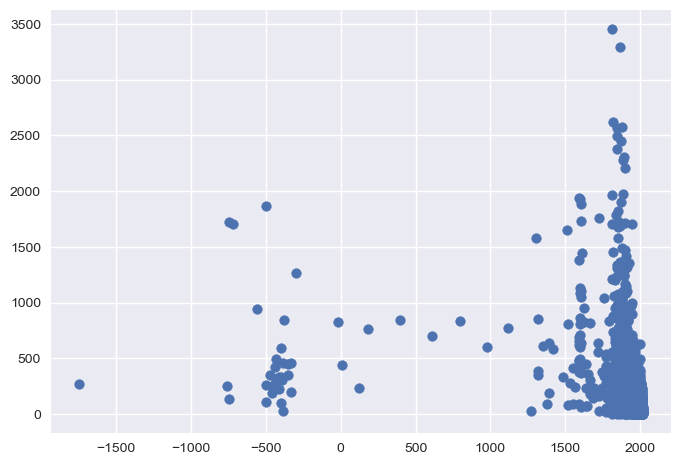

In [28]:
df=pd.read_csv('books.csv')
x = df.original_publication_year
y = df.books_count
plt.scatter(x, y)
plt.show()  

In [29]:
df_books = pd.read_csv('books.csv')
df_books.head(10)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


### Histogram

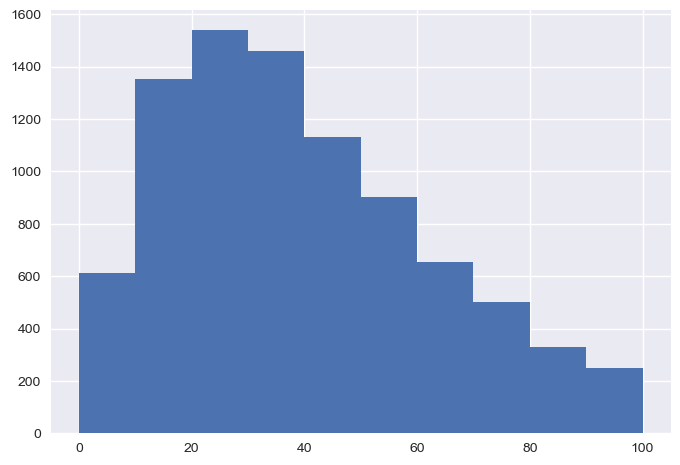

In [30]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
plt.hist(df_books.books_count, bins = bins)
plt.show()

## Pie Chart

In [31]:
df_ratings['rating']

0          5
1          4
2          5
3          5
4          3
          ..
5976474    5
5976475    4
5976476    4
5976477    5
5976478    4
Name: rating, Length: 5976479, dtype: int64

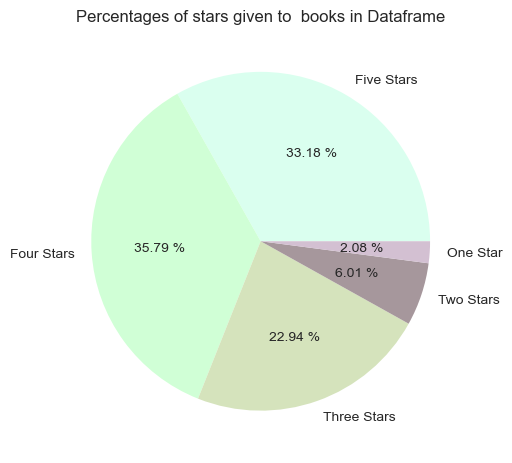

In [32]:
five = df_ratings.loc[df_ratings['rating']== 5].count()[0]
four = df_ratings.loc[df_ratings['rating']== 4].count()[0]
three = df_ratings.loc[df_ratings['rating']== 3].count()[0]
two = df_ratings.loc[df_ratings['rating']== 2].count()[0]
one = df_ratings.loc[df_ratings['rating']== 1].count()[0]
#labeling, and colouring my data.
labels = ["Five Stars", "Four Stars", "Three Stars", "Two Stars", "One Star"]
colors = ["#daffef", "#d0ffd6","#d5e3bc", "#a6979c",'#d3c0d2' ]
#plotting my chart
plt.pie([five, four, three, two, one], labels = labels, colors = colors, autopct ='%.2f %%')

plt.title('Percentages of stars given to  books in Dataframe')
plt.show()